# Recommender Systems

## Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

## Load and preview data

In [2]:
# Ratings Dataset
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
print("Ratings Data:")
ratings.head()

Ratings Data:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
# Movies Dataset
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')
print("Movies Data:")
movies.head()

Movies Data:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Dataset overview and stats

In [4]:
# Basic Statistics
n_movies = len(ratings['movieId'].unique())
n_ratings = len(ratings)
n_users = len(ratings['userId'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movies: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings / n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings / n_movies, 2)}")

Number of ratings: 100836
Number of unique movies: 9724
Number of unique users: 610
Average ratings per user: 165.3
Average ratings per movie: 10.37


## User activity analysis

In [5]:
# Frequency of User Ratings
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
print("User Frequency:")
user_freq.head()

User Frequency:


,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


## Analyze Ratings for specific movies

In [6]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
highest_rated = mean_rating['rating'].idxmax()

print("Lowest Rated Movie:")
print(movies.loc[movies['movieId'] == lowest_rated])

print("Highest Rated Movie:")
print(movies.loc[movies['movieId'] == highest_rated])

print("Ratings for Lowest Rated Movie:")
print(ratings[ratings['movieId'] == lowest_rated])

print("Ratings for Highest Rated Movie:")
print(ratings[ratings['movieId'] == highest_rated])

Lowest Rated Movie:
      movieId         title   genres
2689     3604  Gypsy (1962)  Musical
Highest Rated Movie:
    movieId            title           genres
48       53  Lamerica (1994)  Adventure|Drama
Ratings for Lowest Rated Movie:
       userId  movieId  rating   timestamp
13633      89     3604     0.5  1520408880
Ratings for Highest Rated Movie:
       userId  movieId  rating  timestamp
13368      85       53     5.0  889468268
96115     603       53     5.0  963180003


# Simple Recommender

In [7]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [8]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [9]:
ratings[ratings['movieId']==lowest_rated]

,userId,movieId,rating,timestamp
13633,89,3604,0.5,1520408880


In [10]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


# Collaborative filter

## Create Sparse Matrix for ratings

In [11]:
N = len(ratings['userId'].unique())
M = len(ratings['movieId'].unique())

user_mapper = dict(zip(np.unique(ratings["userId"]), list(range(N))))
movie_mapper = dict(zip(np.unique(ratings["movieId"]), list(range(M))))

user_index = [user_mapper[i] for i in ratings['userId']]
movie_index = [movie_mapper[i] for i in ratings['movieId']]

X = csr_matrix((ratings['rating'], (movie_index, user_index)), shape=(M, N))

X_df = pd.DataFrame(X.toarray())
X_df

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
movie_id = random.randint(0, n_movies)
movies.loc[movies['movieId'] == ratings['movieId'].unique()[movie_id]]

,movieId,title,genres
5640,27397,Joint Security Area (Gongdong gyeongbi guyeok ...,Crime|Drama|Mystery|Thriller|War


In [13]:
neighbor_ids = []

movie_ind = movie_mapper[movie_id]
movie_vec = X[movie_ind]

k = 10
kNN = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric='cosine')
kNN.fit(X)

movie_vec = movie_vec.reshape(1,-1)
neighbour = kNN.kneighbors(movie_vec, return_distance=False)

movie_inv_mapper = dict(zip(list(range(M)), np.unique(ratings["movieId"])))

for i in range(0,k):
    n = neighbour.item(i)
    neighbor_ids.append(movie_inv_mapper[n])

neighbor_ids.pop(0)
neighbor_ids

[34153, 47970, 7888, 3606, 4969, 50160, 2927, 4063, 5685]

## Find similar movies

In [14]:
def find_similar_movies(movie_id, X, k):

  neighbor_ids = []

  movie_ind = movie_mapper[movie_id]
  movie_vec = X[movie_ind]
  k+=1
  kNN = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='cosine')
  kNN.fit(X)
  movie_vec = movie_vec.reshape(1,-1)
  neighbor = kNN.kneighbors(movie_vec, return_distance=False)

  for i in range(0,k):
    n = neighbor.item(i)
    neighbor_ids.append(movie_inv_mapper[n])
  neighbor_ids.pop(0)
  return neighbor_ids

In [15]:
movie_titles = dict(zip(movies['movieId'], movies['title']))
movie_titles

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (199

In [16]:
movie_id = 586
movie_title = movie_titles[movie_id]
movie_title

'Home Alone (1990)'

In [17]:
similar_ids = find_similar_movies(movie_id, X, k=10)

print(f"Since you watched {movie_title}")
for i in similar_ids:
  print(movie_titles[i])

Since you watched Home Alone (1990)
Mrs. Doubtfire (1993)
Lion King, The (1994)
Pretty Woman (1990)
Jurassic Park (1993)
Jumanji (1995)
Speed (1994)
Forrest Gump (1994)
Aladdin (1992)
Mask, The (1994)
Indiana Jones and the Temple of Doom (1984)


In [18]:
rated = ratings.loc[ratings['movieId']==movie_id]

print(rated)

       userId  movieId  rating   timestamp
1067        8      586     3.0   839463702
1428       14      586     3.0   835441451
1820       18      586     3.5  1455748696
2393       19      586     3.0   965707079
2991       20      586     3.0  1054038279
...       ...      ...     ...         ...
91378     592      586     4.0   837350242
91542     594      586     5.0  1109036952
92867     599      586     3.0  1498525239
96084     602      586     1.0   840875757
98783     608      586     1.0  1117504351

[116 rows x 4 columns]


In [19]:
df = X_df.T.copy()
df['userBias'] = df[df!=0].mean(numeric_only=True, axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,9715,9716,9717,9718,9719,9720,9721,9722,9723,userBias
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.366379
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.948276
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.435897
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.555556
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.657399
606,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.786096
607,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.134176
608,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.270270


In [20]:
rated['userId'].values

array([  8,  14,  18,  19,  20,  21,  38,  42,  45,  54,  62,  63,  64,
        66,  68,  83,  84,  91,  94, 102, 103, 104, 109, 116, 117, 132,
       144, 153, 156, 167, 169, 170, 173, 177, 182, 187, 200, 219, 220,
       226, 229, 230, 232, 233, 234, 235, 243, 263, 273, 274, 280, 283,
       287, 288, 292, 294, 304, 307, 321, 322, 330, 334, 344, 349, 354,
       357, 373, 376, 380, 381, 386, 387, 395, 402, 411, 414, 425, 428,
       434, 436, 444, 446, 447, 448, 474, 475, 476, 477, 480, 483, 484,
       489, 491, 509, 512, 514, 517, 520, 522, 524, 525, 530, 534, 541,
       555, 561, 570, 573, 584, 589, 590, 592, 594, 599, 602, 608])

In [21]:
userBias = df.iloc[rated['userId'].values]['userBias']
userBias = userBias.reset_index(drop=True)
userBias

,userBias
0,3.260870
1,3.448148
2,2.607397
3,3.590909
4,3.260722
...,...
111,3.266990
112,4.200000
113,2.991481
114,3.507953


In [22]:
rated = rated.reset_index(drop=True)
rated

,userId,movieId,rating,timestamp
0,8,586,3.0,839463702
1,14,586,3.0,835441451
2,18,586,3.5,1455748696
3,19,586,3.0,965707079
4,20,586,3.0,1054038279
...,...,...,...,...
111,592,586,4.0,837350242
112,594,586,5.0,1109036952
113,599,586,3.0,1498525239
114,602,586,1.0,840875757


In [23]:
filtering = rated['rating']>=userBias
filtering

,0
0,False
1,False
2,True
3,False
4,False
...,...
111,True
112,True
113,True
114,False


In [24]:
recommend = rated.loc[filtering]

print(recommend)

     userId  movieId  rating   timestamp
2        18      586     3.5  1455748696
10       62      586     4.0  1521489913
19      102      586     4.0   835877270
20      103      586     4.0  1431957135
23      116      586     3.5  1337199910
24      117      586     4.0   844162913
30      169      586     5.0  1078284644
38      220      586     4.5  1230061714
40      229      586     3.0   838143590
50      280      586     4.0  1348532002
54      292      586     4.0  1265680476
56      304      586     4.0   891173994
59      322      586     3.5  1217676382
62      344      586     5.0  1420496646
65      357      586     4.0  1348612117
68      380      586     4.0  1494803432
73      402      586     4.0   849601295
74      411      586     4.0   835532644
79      436      586     4.0   833530512
85      475      586     4.5  1498031682
87      477      586     3.0  1200939829
88      480      586     4.0  1179177983
90      484      586     4.0  1342296049
92      491     

## User Bias Analysis

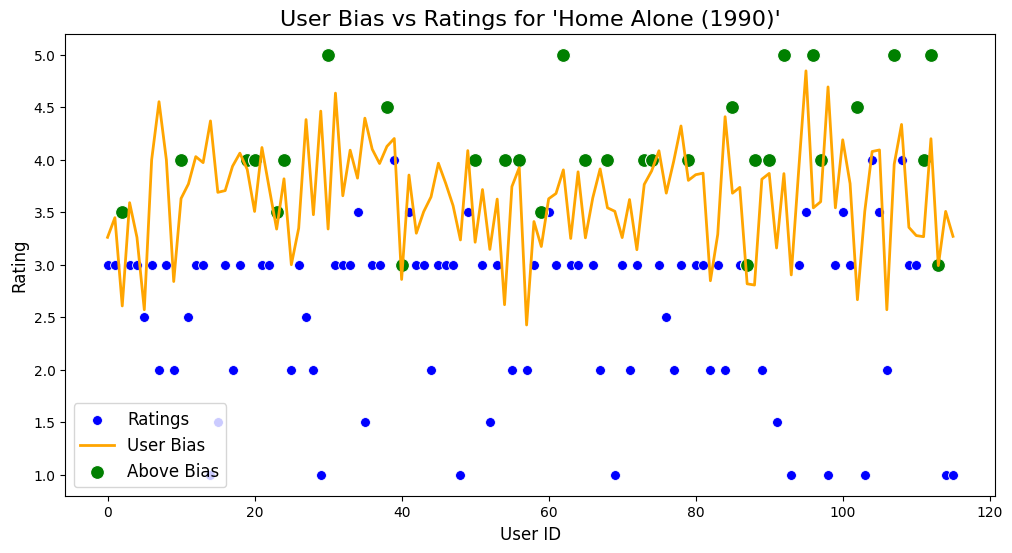

In [25]:
filtered_users = rated[filtering]

plt.figure(figsize=(12, 6))

sns.scatterplot(x=rated.index, y=rated['rating'], label="Ratings", color="blue", s=50)

sns.lineplot(x=rated.index, y=userBias, label="User Bias", color="orange", linewidth=2)


sns.scatterplot(x=filtered_users.index, y=filtered_users['rating'], label="Above Bias", color="green", s=100)

plt.title(f"User Bias vs Ratings for '{movie_title}'", fontsize=16)
plt.xlabel("User ID", fontsize=12)
plt.ylabel("Rating", fontsize=12)
plt.legend(fontsize=12)
plt.show()